# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제
- 담당: 이녕민M

## Import Libraries

In [1]:
!apt-get update && apt-get install -y python3-opencv

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease                        
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]      
Get:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Packages [917 kB]
Get:11 http://security.ubuntu.com/ubuntu bionic-security/main amd64 Packages [2557 kB]
Get:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]  

In [2]:
!pip install sklearn

     |████████████████████████████████| 26.7 MB 15.0 MB/s eta 0:00:01
     |████████████████████████████████| 306 kB 34.5 MB/s eta 0:00:01
     |████████████████████████████████| 41.6 MB 27.1 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=85bb79640180c846bde7a9eb20fc02e2e5f1ee8c39e885129c580644c3ec2ff0
  Stored in directory: /root/.cache/pip/wheels/22/0b/40/fd3f795caaa1fb4c6cb738bc1f56100be1e57da95849bfc897
Successfully built sklearn


In [11]:
! pip install opencv-python
! pip install pandas


     |████████████████████████████████| 11.7 MB 14.3 MB/s eta 0:00:01


In [115]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

## Set Arguments & hyperparameters

In [116]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [117]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= 'data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 128

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader

#### Train & Validation Set loader

In [118]:
class CustomDataset(Dataset):
    def __init__(self, data_dir, mode, input_shape):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode == 'train':
            self.db = self.db[:int(len(self.db) * 0.9)]
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
            
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])

        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'train',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['COVID']


## Model

In [119]:
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=25, kernel_size=5)
        
        self.fc1 = nn.Linear(in_features=25*29*29, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 128, 128) -> (32, 8, 62, 62)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 62, 62) -> (32, 25, 29, 29)
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        
        output = self.softmax(x)
        
        return output

In [120]:
import timm
import torch

# timm 에서  상
avail_models = timm.list_models(pretrained=False)
avail_models

['adv_inception_v3',
 'bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_224_in22k',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_224_in22k',
 'beit_large_patch16_384',
 'beit_large_patch16_512',
 'botnet26t_256',
 'botnet50ts_256',
 'cait_m36_384',
 'cait_m48_448',
 'cait_s24_224',
 'cait_s24_384',
 'cait_s36_384',
 'cait_xs24_384',
 'cait_xxs24_224',
 'cait_xxs24_384',
 'cait_xxs36_224',
 'cait_xxs36_384',
 'coat_lite_mini',
 'coat_lite_small',
 'coat_lite_tiny',
 'coat_mini',
 'coat_tiny',
 'convit_base',
 'convit_small',
 'convit_tiny',
 'convmixer_768_32',
 'convmixer_1024_20_ks9_p14',
 'convmixer_1536_20',
 'convnext_base',
 'convnext_base_384_in22ft1k',
 'convnext_base_in22ft1k',
 'convnext_base_in22k',
 'convnext_large',
 'convnext_large_384_in22ft1k',
 'convnext_large_in22ft1k',
 'convnext_large_in22k',
 'convnext_small',
 'convnext_tiny',
 'convnext_tiny_hnf',
 'convnext_xlarge_384_in22ft1k',
 'convnext_xlarge_in22ft1k',
 'convnext_x

In [102]:
from torch import nn
import torch.nn.functional as F
import timm

efficientnet_b4_ns = timm.create_model('tf_efficientnet_b4_ns', pretrained = False)

In [103]:
efficientnet_b4_ns

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [104]:
efficientnet_b4_ns.classifier = nn.Sequential(
    nn.Linear(in_features=1792, out_features=625), #1792 is the orginal in_features
    nn.ReLU(), #ReLu to be the activation function
    nn.Dropout(p=0.3),
    nn.Linear(in_features=625, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=2), 
)

efficientnet_b4_ns

EfficientNet(
  (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
        (bn1): BatchNorm2d(48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(12, 48, kernel_size=(1, 1), stride=(1, 1))
          (gate): Sigmoid()
        )
        (conv_pw): Conv2d(48, 24, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
     

In [112]:

from torchsummary import  summary
efficientnet_b4_ns
summary(efficientnet_b4_ns,input_size=(3,224,224))

RuntimeError: CUDA error: device-side assert triggered

In [78]:
import torch.nn.functional as F

class resnet(nn.Module):
    def __init__(self, num_classes):
        super(resnet, self).__init__()
        self.model = resnet_18()
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_img):
        x = self.model(input_img)
        x = self.softmax(x)
        return x


In [81]:
def show_image(image,label,get_denormalize = True):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    if get_denormalize == True:
        image = image*std + mean
        image = np.clip(image,0,1)
        plt.imshow(image)
        plt.title(label)
        
    else: 
        plt.imshow(image)
        plt.title(label)

def show_grid(image,title = None):
    
    image = image.permute(1,2,0)
    mean = torch.FloatTensor([0.485, 0.456, 0.406])
    std = torch.FloatTensor([0.229, 0.224, 0.225])
    
    image = image*std + mean
    image = np.clip(image,0,1)
    
    plt.figure(figsize=[15, 15])
    plt.imshow(image)
    if title != None:
        plt.title(title)

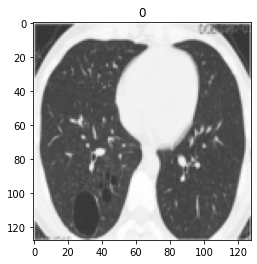

In [94]:
import matplotlib.pyplot as plt 

img, label = train_dataset[0]
show_image(img, label)

In [98]:
class_name = [1, 0]

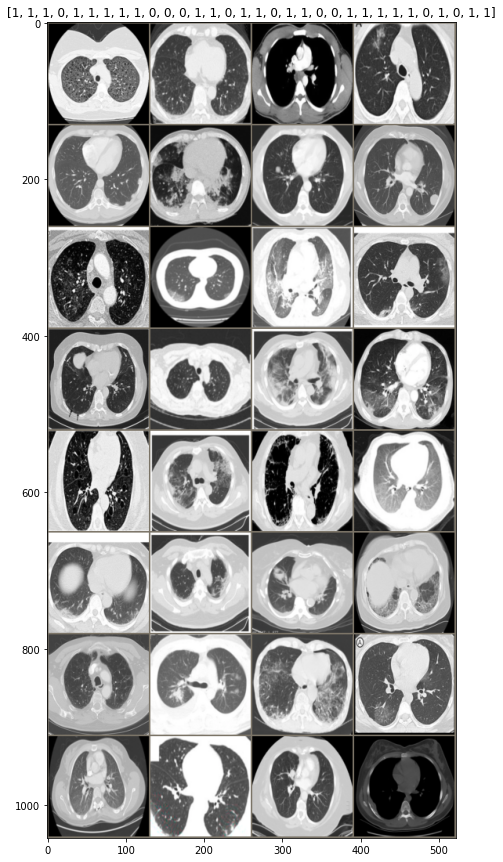

In [99]:
from torchvision.utils import make_grid
dataiter = iter(train_dataloader)
images,labels = dataiter.next()

out = make_grid(images,nrow=4)

show_grid(out,title = [class_name[x] for x in labels])

## Utils
### EarlyStopper

In [121]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [122]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)

### Metrics

In [123]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [31]:
ls

baseline_cnn.ipynb  data/


In [124]:
# Load dataset & dataloader
train_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)
print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading val dataset..
Train set samples: 581 Val set samples: 65


#### Load model and other utils

In [125]:
len(train_dataset)

581

In [126]:
# Load Model
model = custom_CNN(NUM_CLS).to(DEVICE)
# model = resnet_18(NUM_CLS).to(DEVICE)
# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn


# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

RuntimeError: CUDA error: device-side assert triggered

### epoch 단위 학습 진행

In [67]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'best.pt')


  0% 0/30 [00:01<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered

## Inference
### 모델 로드

In [45]:
TRAINED_MODEL_PATH = 'best.pt'

### Load dataset

In [ ]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [ ]:
# Load dataset & dataloader
test_dataset = TestDataset(data_dir=DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 추론 진행

In [ ]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

# Prediction
file_lst = []
pred_lst = []
prob_lst = []
model.eval()
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        print(pred)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

### 결과 저장

In [ ]:
df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# df.sort_values(by=['file_name'], inplace=True)
df.to_csv('prediction.csv', index=False)